:**참고문헌: 핸즈온 머신러닝(2판), 올레리앙 제롱 지음, 박해선 옮김, 4장 – 모델 훈련**

강의계획
- 로지스틱 회귀(Logistic regression)
  - 확률 추정
  - 훈련과 비용 함수(training and cost function) 
  - 결정 경계(decision boundary)
  - 소프트맥스 회귀(soeftmax regression) 또는 다항 로지스틱 회귀(multiple logistic regression)
  - 예제코드: 조기 종료를 사용한 배치 경사하강법으로 스프트맥스 회귀 구현하기  
  

표기법 정리
*   ${y}$은 예측할 값
*   ${x}$은 입력 값
*   ${p}$은 예측 확률값

*   $\hat{y}$은 예측값
*   $\hat{p}$은 예측된 확률값

*   $y_k^{(i)}$는 $i$번째 샘플이 클래스 $k$에 속할 타킷 확률
*   $x_k^{(i)}$는 $i$번째 샘플이 클래스 $k$에 속할 입력 값
*   $\boldsymbol{\theta}$는 모델 파라미터 (편향 $\boldsymbol{\theta}_0$과 특성의 가중치 $\boldsymbol{\theta}_1, \boldsymbol{\theta}_2, ..., \boldsymbol{\theta}_n$을 포함). 

*   $K$은 클래스의 수
*   $m$은 샘플의 수



# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 로지스틱 회귀 (logistic regression)

회귀 알고리즘은 분류 모델로 사용할 수 있습니다. 로지스틱 회귀는 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용됩니다(예, 이메일이 스팸일 확률은 얼마인가?). 추정 확률이 50%가 넘으면 모델은 그 샘플이 해당 클래스에 속한다고 예측합니다(즉, 레이블이 '1'인 양성 클래스(positive class) 아니면 클래스에 속하지 않는다고 예측합니다(즉, 레이블이 '0'인 음성 클래스(negative class). 이를 이진 분류기(binary classifier)라고 합니다.

## 확률 추정

그렇다면 로지스틱 회귀는 실제 어떻게 작동하는 걸까요? 선형 회귀 모델과 같이 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산합니다 (그리고 편향을 더합니다). 대신 선형 회귀처럼 바로 결과를 출력하지 않고 결과값의 로지스틱(logistic)을 출력합니다 [식 4-13].

**식 4-13: 로지스틱 회귀 모델의 확률추정(벡터 표현식)**


$\hat{\rho}=h_\theta(\mathbf{x})=\sigma (\theta^T\mathbf{x} )$


로지스틱($\sigma (\cdot)$으로 표시합니다)은 0과 1 사의 값을 출력하는 시그모이드 함수(sigmoid function)입니다 (즉 S형태 입니다). 이 함수는 [식 4-14]와 같이 정의가 됩니다.

식 4-14 로지스틱 함수

$\sigma(t)=\frac{1}{1+exp(-t)} $

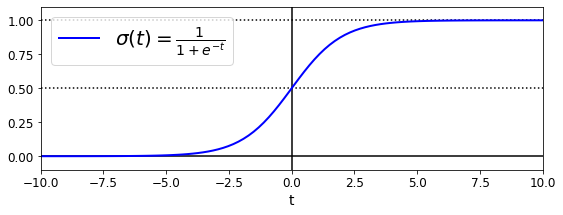

In [ ]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

로지스틱 회귀 모델이 샘플 $\mathbf{x}$가 양성 클래스에 속할 활률 $\hat{\rho}=h_\theta(\mathbf{x})$를 추정하면 이에 대한 예측 $\hat{y}$을 쉽게 구할 수 있습니다 [식 4-15].


식 4-15 로지스틱 회귀 모델 예측

$
\hat{y} =
\begin{cases}
  0 & \text{if } \hat{p} < 0.5 일때 \\
  1 & \text{if } \hat{p} > 0.5 일때
\end{cases}
$


t < 0이면 $\sigma(t)$ < 0.5이고, $t\geq0$이면  $\sigma(t) \geq 0.5$이므로 로지스틱 회귀 모델은 $\mathbf{\theta}^T\textbf{x}$ 가 양수 일때 1 (양성 클래스) 이라고 예측하고, 음수일 때 0 (음성 클래스)이라고 예측합니다.

## 훈련과 비용 함수

이제 로지스특 회귀 모델이 어덯게 확률을 추정하고 예측하는지 알았습니다. 그럼 어떻게 훈련을 시킬까요? 훈련의 목적은 양성 샘플(y=1)에 대해서는 높은 확률을 추정하고 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 $\theta$를 찾는 것입니다. 이러한 아디어가 하나의 훈련 샘플 $\mathbf{x}$에 대해 나타낸 비용 함수인 [식 4-16]에서 드러나 있습니다.

**식 4-16: 하나의 훈련 샘플에 대한 비용 함수**

$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$


이 비용 함수는 $t$가 0에 가까워지면 $-\log(t)$가 매우 커지므로 타당하다 할 수 있습니다. 그러므로 모델이 양성 샘플을 0에 가까운 확률로 추정하면 비용이 크게 증가할 것입니다. 또한 음성 샘플을 1에 가까운 확률로 추정해도 비용이 증가할 것입니다. 반면에 $t$가 1에 가까우면 $-\log(t)$는 0에 가까워집니다. 따라서 기대한 대로 음성 샘플의 확률을 0에 가깝게 추정하거나 양성 샘플의 확률을 1에 가깝게 추정하면 비용은 0에 가까워질 것입니다. 

전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것입니다. 이를 로그 손실(log loss)라 부르며 [식 4-17]처럼 하나의 식으로 쓸 수가 있습니다. 


**식 4-17: 로지스틱 회귀 비용 함수(로그 손실)**

$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$

안타깝게도 이 비용 함수의 최솟값으로 계산하는 알려진 해가 없습니다. 하지만, 이 비용 함수는 볼록 함수이므로 경사 하강법이 전역 최솟값을 찾는 것을 보장합니다(학습률이 너무 크지 않고 충분히 기다릴 시간이 있다면). 이 비용 함수의 $j$번째 모델 파라미터 $\theta_j$에 대해 편미분을 하면 [식 4-18]과 같습니다. 





**식 4-18: 로지스틱 비용 함수의 편도 함수**

$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$

이 식은 [식 4-5]와 매우 비슷해 보입니다. 각 샘플에 대해 예측 오차를 계산하고 $j$번째 특성값을 곱해서 모든 훈련 샘플에 대해 평균을 냅니다. 모든 편도함수를 포함한 그레이디언트 벡터를 만들면 배치 경사 하강법 알고리즘을 사용할 수 있습니다. 이제 로지스틱 회귀 모델을 훈련 시키는 방법에 대해 알게 되었습니다. 물론 확률적 경사 하강법은 한 번에 하나의 샘플을 사용하고 미니배치 경사 하강법은 한 번에 하나의 미니배치를 사용합니다. 

참고 블로그#1: https://eremo2002.tistory.com/63


참고 블로그#2: https://ichi.pro/ko/lojiseutig-hoegwileul-sayonghan-gyeongsa-sangseung-guhyeon-139995591965729


## 결정 경계

로지스틱 회귀를 설명하기 위해 붓꽃 데이터셋을 사용하겠습니다. 이 데이터셋은 세 개의 품종, Iris-Setosa, Iris-Versicolor, Iris-Virginica에 속하는 붓꽃 150개의 꽃잎(petal)과 꽃받침(sepal)이 너비와 길이를 담고 있습니다(그림 참조)

<img src="https://raw.githubusercontent.com/Hyun-chul/DeepLearning/main/4-22.png">

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [ ]:
X = iris["data"][:, 3:]  # 꽃잎 너비
y = (iris["target"] == 2).astype(int)  # Iris virginica이면 1 아니면 0

**노트**: 향후 버전이 바뀌더라도 동일한 결과를 만들기 위해 사이킷런 0.22 버전의 기본값인 `solver="lbfgs"`로 지정합니다.

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

꽃잎의 너비가 0~3 cm 꽃에 대해 모델의 추정 확률을 계산해보겠습니다.

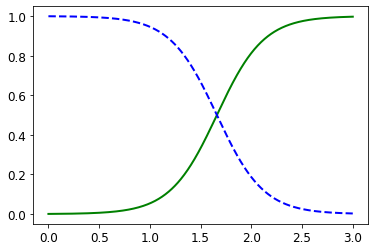

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

책에 실린 그림은 조금 더 예쁘게 꾸몄습니다:

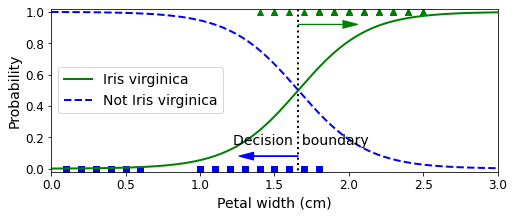

In [ ]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

Iris-Verginica (삼각형 표시)의 꽃잎 너비는 1.4-2.5cm에 분포합니다. 반면 다른 붓꽃(사각형 표시)는 일반적으로 꽃잎 너비가 더 작아 0.1~1.8cm에 분포합니다. 그래서 약간 중첩되는 부분이 있습니다. 꽃잎 너비가 2cm 이상인 꽃은 분류기가 Iris-Verginica라고 강하게 확신합니다 (이 클래스에 대해 높은 확률을 출력합니다). 반면 1 cm 아래면 Iris-Verginica가 아니라고 강하게 확신합니다('Iris-Verginica 아님'클래스에 대한 확률이 높습니다). 이 두 극단 사이에서는 분류가 확실하지 않습니다. 하지만 어쨌든 클래스를 예측하려고 하면 가장 가능성 높은 클래스를 반환할 것입니다. 그렇기 때문에 양족의 확률이 똑같이 50%가 되는 1.6cm 근방에서 결정 경계(decision boundary)가 만들어집니다. 꽃잎 너비가 1.6cm보다 크면 분류기는 Iris-Verginica로 분류하고, 그보다 작으면 아니라고 예측할 것입니다 (아주 확실하지 않더라도). 

In [ ]:
decision_boundary

array([1.66066066])

In [ ]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

아래의 예제는 데이터셋을 꽃잎 너비와 꽃잎 길이 두 개의 특성을 이용하여 로지스틱 회귀를 수행한 예제입니다. 

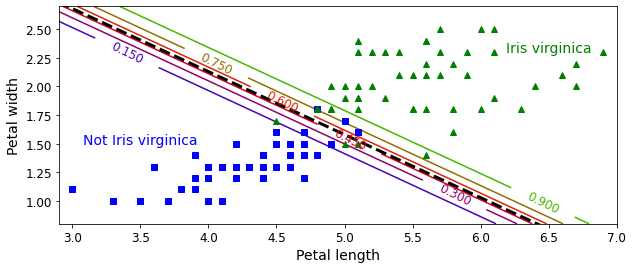

In [ ]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
#save_fig("logistic_regression_contour_plot")
plt.show()

## 소프트맥스 회귀 (softmax regression) 또는 다항 로지스틱 회귀 (multinomial logistic regression)

로지스틱 회귀 모델은 여러 개의 이진 분류기(binary classifier)를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화될 수 있습니다. 이를 소프트맥스 회귀 또는 다항 로지스틱 회귀라고 합니다. 

개념은 매루 간단합니다. 샘플 $\mathbf{x}$가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 $k$에 대한 점수 $s_k(\mathbf{x})$를 계산하고, 그 점수에 소프트맥스 함수(softmax function) 또는 정규화된 지수 함수(normalized exponential function)를 적용하여 각 클래스의 확률을 추정합니다. $s_k(\mathbf{x})$를 계산하는 식은 선형 회귀 예측을 위한 식과 매우 비슷해서 친숙할 것입니다 [식 4-19].

**식 4-19: 클래스 $k$에 대한 소프트맥수 점수**

$s_k(\mathbf{x})$ = $(\theta^{(k)})^T\mathbf{x}$


각 클래스는 자신만의 파라미터 벡터 $\theta^{(k)}$가 있습니다. 이 벡터들은 파라미터 행렬(parameter matrix) $\Theta$에 행으로 저장됩니다.

 샘플 $\mathbf{x}$에 대해 각 클래스의 점수가 계산되면 소프트맥수 함수 [식 4-20]를 통과시켜 클래스 $k$에 속할 확률 $\hat{p}_k$을 추정할 수 있습니다. 이 함수는 각 점수에 지수 함수를 적용한 후 정규화합니다 (즉, 모든 지수 함수 결과의 합으로 나눕니다.). 일반적응로 이 점수를 로짓 또는 로그-오즈라고 부릅니다. 

**식 4-20: 소프트맥스 함수**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$

*   $K$는 클래수 입니다. 
*   $\mathbf{s}(\mathbf{x})$는 샘플 $\mathbf{x}$에 대한 각 클래스의 점수를 담은 벡터입니다. 
*   $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k$는 샘플 $\mathbf{x}$에 대한 각 클래스의 점수가 주어졌을 때 이 샘플의 클래스 $k$에 속할 추정 확률 입니다.


로지스틱 회귀 분류기가 마찬가지로 소프트맥스 회귀 분류기는 [식 4-21]처럼 추정 확률이 가장 높은 클래스(그냥 가장 높은 점수를 가진 클래스)를 선택합니다. 

**식 4-21: 소프트맥스 회귀 분류기의 예측**

$\hat{y} = \underset{k}{\textbf{argmax}}(\sigma\left(\mathbf{s}(\mathbf{x})\right)_k) = \underset{k}{\textbf{argmax}}(\mathbf{s_k}(\mathbf{x})) = \underset{k}{\textbf{argmax}}((\mathbf{\theta^{(k)})^T}\mathbf{x})$

argmax 연산은 함수를 최대화하는 변수의 값을 반환합니다. 이식에서는 추정 확률 $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k$가 최대인 $k$값을 반환합니다.

Tip: 소프트 맥스 회귀 분류기는 한 번에 하나의 클래스만 예측합니다(즉, 다중 클래스(multiclass)지 다중출력(multioutput)은 아닙니다). 그래서 종류가 다른 붗꽃 같이 상호 배타적인 클래스에서만 사용해야 합니다. 하나의 사진에서 여러 사람의 얼굴을 인식하는 데는 사용할 수 없습니다. 

모델이 어떻게 확률을 추정하고 예측을 만드는지 알았으므로 훈련 방법에 대해 살펴보겟습니다. 모델이 타킷 클래스에 대해서는 높은 확률을(그리고 다른 클래스에 대해서는 낮은 확률을)추정 하도록 만드는 것이 목접입니다. [식 4-22]의 크로스 엔트로피(cross entropy)비용 함수를 최소화하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제하므로 이 목적에 부합합니다. 크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지 측정하는 용도로 종종 사용됩니다.

**식 4-22: 크로스 엔트로피 비용 함수**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

* 이 식에서는 $y_k^{(i)}$는 $i$번째 샘플이 클래스 $k$에 속할 타킷 확률입니다. 일반적으로 샘플이 클래스에 속하는지 아닌지에 따라 1 도는 0이 됩니다. 

크로스 엔트로피 관련 자세한 내용은 동영상을 참고하시면 됩니다.

https://homl.info/xentropy

딱 두 개의 클래스가 있을 때 (K =2) 이 비용 함수는 로지스틱 회귀의 비용 함수와 같습니다. 이 비용 함수의 $\theta^{(k)}$에 대한 그레이디언트 벡터는 [식 4-23]과 같습니다.


**식 4-23: 클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

이제 각 클래스에 대한 그레이디언트 벡터를 계산할 수 있으므로 비용 함수를 최소화하기 위한 파라미터 행렬 $\Theta$를 찾기 위해 경사 하강법(또는 다른 최적화 알고리즘)을 사용 할 수 있습니다. 

소프트맥스 회귀를 사용해 붗꽃을 세 개의 클래스로 분류해보겠습니다. 사이킷런의 Logistic Regression은 클래스가 둘 이상일 때 기본적으로 일대다 전략을 사용합니다. 하지만, multi_class 매개 변수를 "multinomial"로 바꾸면 소프트맥스 회귀를 사용할 수 있습니다. 소프트맥스 회귀를 사용하려면 solver 매개변수에 "lbfgs"와 같이 소프트맥스 회귀를 지원하는 알고리즘을 지정해야 합니다. 예제 코드를 통해 자세히 알아보겠습니다.

In [ ]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

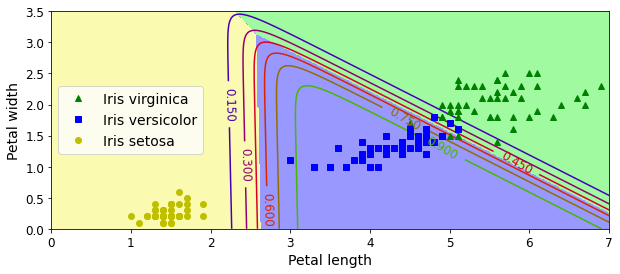

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
#save_fig("softmax_regression_contour_plot")
plt.show()

위 그림은 만들어진 결정 경계를 배경색으로 구분하여 나태내고 있습니다. 클래스 사이의 결정 경계가 모두 선형입니다. 또한 Iris-Versicolor 클래스에 대한 확률을 곡선으로 나타냈습니다 (즉, 0.450인 직선은 45% 확률 경계를 나타냅니다). 이 모델이 추정 확률 50% 이하인 클래스를 예측할 수도 있다는 점을 주목하세요. 예를 들어 모든 결정 경계가 만나는 지점에서는 모든 클래스가 동일하게 33%의 추정 확률을 가집니다.

In [ ]:
# 꽃잎의 길이가 5cm, 너비가 2cm인 붓꽃을 발견했다고 가정하고 이 붓꽃의 품종이 무엇인지 모델에 질의하면 94.2%의 확류로 Iris-Virginica (클래스 2)라고 (또는 5.8% 확률로 Iris-Versicolor라고) 출력할 것입니다.
softmax_reg.predict([[5, 2]])

array([2])

ㄱ

In [ ]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

## 연습문제. 조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀 구현하기
(사이킷런을 사용하지 않고)

먼저 데이터를 로드합니다. 앞서 사용했던 Iris 데이터셋을 재사용하겠습니다.

In [ ]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

모든 샘플에 편향을 추가합니다 ($x_0 = 1$):

In [ ]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

결과를 일정하게 유지하기 위해 랜덤 시드를 지정합니다:

In [ ]:
np.random.seed(2042)

데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 나누는 가장 쉬운 방법은 사이킷런의 `train_test_split()` 함수를 사용하는 것입니다. 하지만 이 연습문제의 목적은 직접 만들어 보면서 알고리즘을 이해하는 것이므로 다음과 같이 수동으로 나누어 보겠습니다:

In [ ]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

타깃은 클래스 인덱스(0, 1 그리고 2)이지만 소프트맥스 회귀 모델을 훈련시키기 위해 필요한 것은 타깃 클래스의 확률입니다. 각 샘플에서 확률이 1인 타깃 클래스를 제외한 다른 클래스의 확률은 0입니다(다른 말로하면 주어진 샘플에 대한 클래스 확률이 원-핫 벡터입니다). 클래스 인덱스를 원-핫 벡터로 바꾸는 간단한 함수를 작성하겠습니다:

In [ ]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

10개 샘플만 넣어 이 함수를 테스트해 보죠:

In [ ]:
y_train[:10]

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0])

In [ ]:
to_one_hot(y_train[:10])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

잘 되네요, 이제 훈련 세트와 테스트 세트의 타깃 클래스 확률을 담은 행렬을 만들겠습니다:

In [ ]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

이제 소프트맥스 함수를 만듭니다. 다음 공식을 참고하세요:

$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [ ]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

훈련을 위한 준비를 거의 마쳤습니다. 입력과 출력의 개수를 정의합니다:

In [ ]:
n_inputs = X_train.shape[1] # == 3 (특성 2개와 편향)
n_outputs = len(np.unique(y_train))   # == 3 (3개의 붓꽃 클래스)

이제 좀 복잡한 훈련 파트입니다! 이론적으로는 간단합니다. 그냥 수학 공식을 파이썬 코드로 바꾸기만 하면 됩니다. 하지만 실제로는 꽤 까다로운 면이 있습니다. 특히, 항이나 인덱스의 순서가 뒤섞이기 쉽습니다. 제대로 작동할 것처럼 코드를 작성했더라도 실제 제대로 계산하지 못합니다. 확실하지 않을 때는 각 항의 크기를 기록하고 이에 상응하는 코드가 같은 크기를 만드는지 확인합니다. 각 항을 독립적으로 평가해서 출력해 보는 것도 좋습니다. 사실 사이킷런에 이미 잘 구현되어 있기 때문에 이렇게 할 필요는 없습니다. 하지만 직접 만들어 보면 어떻게 작동하는지 이해하는데 도움이 됩니다.

구현할 공식은 비용함수입니다:

$J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}$

그리고 그레이디언트 공식입니다:

$\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}$

$\hat{p}_k^{(i)} = 0$이면 $\log\left(\hat{p}_k^{(i)}\right)$를 계산할 수 없습니다. `nan` 값을 피하기 위해 $\log\left(\hat{p}_k^{(i)}\right)$에 아주 작은 값 $\epsilon$을 추가하겠습니다.

In [ ]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.47292289721922487
3500 0.44824244188957774
4000 0.42786510939287936
4500 0.41060071429187134
5000 0.3956780375390374


소프트맥스 모델을 훈련시켰습니다. 모델 파라미터를 확인해 보겠습니다:

In [ ]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

검증 세트에 대한 예측과 정확도를 확인해 보겠습니다:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

이 모델이 매우 잘 작동하는 것 같습니다. 연습을 위해서 $\ell_2$ 규제를 조금 추가해 보겠습니다. 다음 코드는 위와 거의 동일하지만 손실에 $\ell_2$ 페널티가 추가되었고 그래디언트에도 항이 추가되었습니다(`Theta`의 첫 번째 원소는 편향이므로 규제하지 않습니다). 학습률 `eta`도 증가시켜 보겠습니다.

In [ ]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.5036400750148942
1500 0.49468910594603216
2000 0.4912968418075476
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.48886433374493027
5000 0.48884031207388184


추가된 $\ell_2$ 페널티 때문에 이전보다 손실이 조금 커보이지만 더 잘 작동하는 모델이 되었을까요? 확인해 보죠:

In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

와우, 완벽한 정확도네요! 운이 좋은 검증 세트일지 모르지만 잘 된 것은 맞습니다.

이제 조기 종료를 추가해 보죠. 이렇게 하려면 매 반복에서 검증 세트에 대한 손실을 계산해서 오차가 증가하기 시작할 때 멈춰야 합니다.

In [ ]:
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # 규제 하이퍼파라미터
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "조기 종료!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580261
2000 0.5331959249285545
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327978 조기 종료!


In [ ]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

1.0

여전히 완벽하지만 더 빠릅니다.

이제 전체 데이터셋에 대한 모델의 예측을 그래프로 나타내 보겠습니다:

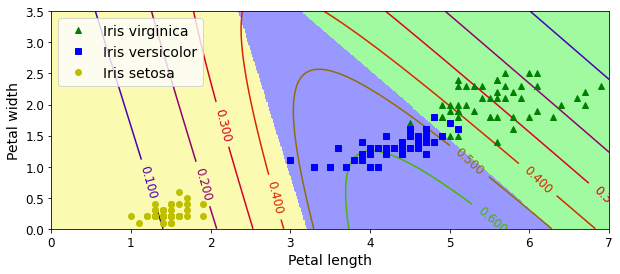

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

이제 테스트 세트에 대한 모델의 최종 정확도를 측정해 보겠습니다:

In [ ]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9333333333333333

완벽했던 최종 모델의 성능이 조금 떨어졌습니다. 이런 차이는 데이터셋이 작기 때문일 것입니다. 훈련 세트와 검증 세트, 테스트 세트를 어떻게 샘플링했는지에 따라 매우 다른 결과를 얻을 수 있습니다. 몇 번 랜덤 시드를 바꾸고 이 코드를 다시 실행해 보면 결과가 달라지는 것을 확인할 수 있습니다.